In [6]:
import pickle
import shap
import numpy as np
from rdkit.Chem import PandasTools, AllChem, rdFingerprintGenerator
from pandas import read_csv, DataFrame
from random import seed

In [8]:
data = read_csv('../../../DATABASE/no_missing_data.csv')
data

,molecule,smiles,max_abs,max_em,solvent,dc,etn
0,BTD-QN,c4cnc3c(Nc1cccc2nsnc12)cccc3c4,445.0,620.0,DMSO,46.8260,0.444
1,BTD-QN,c4cnc3c(Nc1cccc2nsnc12)cccc3c4,445.0,565.0,H2O,78.3553,1.000
2,BTD-QN,c4cnc3c(Nc1cccc2nsnc12)cccc3c4,440.0,575.0,AcOEt,6.0200,0.228
3,BTD-QN,c4cnc3c(Nc1cccc2nsnc12)cccc3c4,450.0,615.0,DCM,8.9300,0.309
4,BTD-QN,c4cnc3c(Nc1cccc2nsnc12)cccc3c4,440.0,615.0,ACN,35.6880,0.460
...,...,...,...,...,...,...,...
696,Priscila-5,C(C#Cc1ccc(C#CCN(c2ccccc2)c3ccccc3)c4nsnc14)N(...,380.0,536.0,DCM,8.9300,0.309
697,Priscila-5,C(C#Cc1ccc(C#CCN(c2ccccc2)c3ccccc3)c4nsnc14)N(...,374.0,549.0,ACN,37.5000,0.460
698,Priscila-7,C(C#Cc1ccc(C#CCN(c2ccccc2)c3ccccc3)c4nsnc14)N5...,376.0,570.0,DIOX,2.2500,0.164
699,Priscila-7,C(C#Cc1ccc(C#CCN(c2ccccc2)c3ccccc3)c4nsnc14)N5...,377.0,560.0,DCM,8.9300,0.309


In [12]:
seed(0)

np.random.seed(0)


PandasTools.AddMoleculeColumnToFrame(data, 'smiles', 'ROMol')
        # Create the fingerprint generator
fp_gen = rdFingerprintGenerator.GetMorganGenerator(radius = 4, fpSize = 2048)

# Generate fingerprints for each molecule
morgan_fps = [list(fp_gen.GetFingerprint(m)) for m in data['ROMol']]

morgan_df = DataFrame(morgan_fps)

morgan_df.columns = ['MF_' + str(j) for j in morgan_df.columns]
morgan_df['etn'] = data['etn'].to_numpy()
# morgan_df['max_abs'] = data['max_abs'].to_numpy()
# morgan_df['max_em'] = data['max_em'].to_numpy()
# morgan['dc'] = data['dc'].values
morgan_df

,MF_0,MF_1,MF_2,MF_3,MF_4,MF_5,MF_6,MF_7,MF_8,MF_9,...,MF_2039,MF_2040,MF_2041,MF_2042,MF_2043,MF_2044,MF_2045,MF_2046,MF_2047,etn
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.444
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1.000
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.228
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.309
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.460
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
696,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.309
697,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.460
698,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.164
699,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.309


In [13]:
seed(0)
em_model = pickle.load(open('lgbm_kf_max_abs.pkl', 'rb'))
abs_model = pickle.load(open('lgbm_kf_max_em.pkl', 'rb'))


In [14]:
seed(0)
explainer_em = shap.TreeExplainer(em_model)
explainer_abs = shap.TreeExplainer(abs_model)


shap_values_em = explainer_em.shap_values(morgan_df.to_numpy())
shap_values_abs = explainer_abs.shap_values(morgan_df.to_numpy())

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


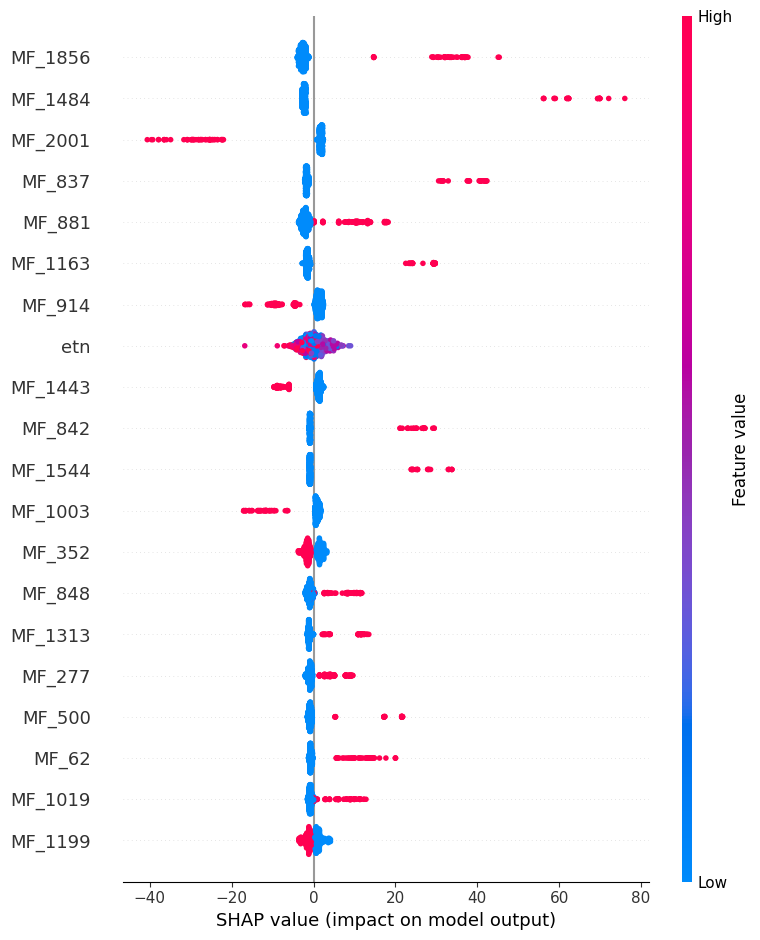

In [16]:
shap.summary_plot(shap_values_em, morgan_df, show=False)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


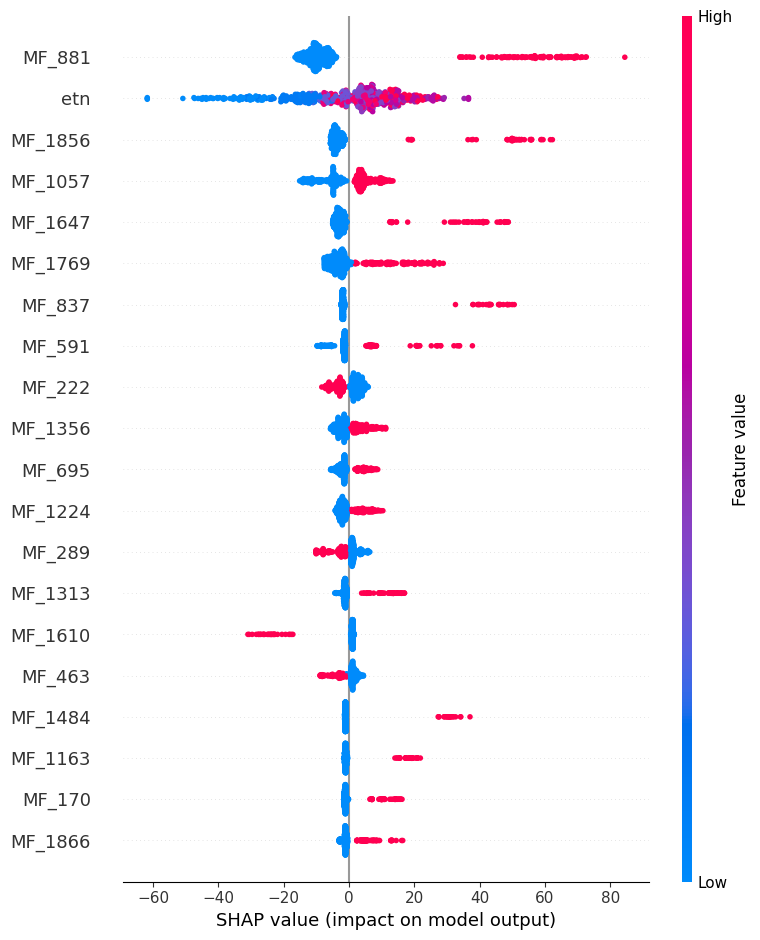

In [17]:
shap.summary_plot(shap_values_abs, morgan_df, show=False)

In [27]:
vals = np.abs(shap_values_em).mean(0)
shap_importance = DataFrame(list(zip(morgan_df.columns, vals)), columns=['col_name', 'feature_importance_vals'])

top10_morgan = shap_importance.nlargest(12, 'feature_importance_vals')

top10_morgan = top10_morgan.drop([2048])

top10_morgan

,col_name,feature_importance_vals
1856,MF_1856,4.785123
1484,MF_1484,4.318995
2001,MF_2001,3.761436
837,MF_837,3.181935
881,MF_881,3.133849
1163,MF_1163,2.928683
914,MF_914,2.227978
1443,MF_1443,2.114241
842,MF_842,1.785058
1544,MF_1544,1.701202


Molecule_BTD-APPh
Morgan Fingerprint: 1856
Smiles: N(c1ccccn1)c2ccc(c3ccccc3)c4nsnc24


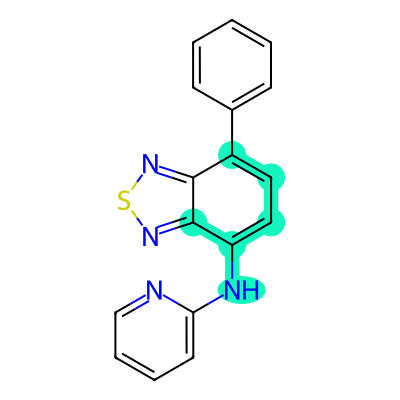

Molecule_BCZ-BTD-AD
Morgan Fingerprint: 1484
Smiles: CC1(C)C2=C(C=CC=C2)N(C3=C1C=CC=C3)C4=CC=C(C5=CC(=CC(=C5)N6C7=C(C=CC=C7)C8=C6C=CC=C8)N9C%10=C(C=CC=C%10)C%11=C9C=CC=C%11)C%12=NSN=C4%12


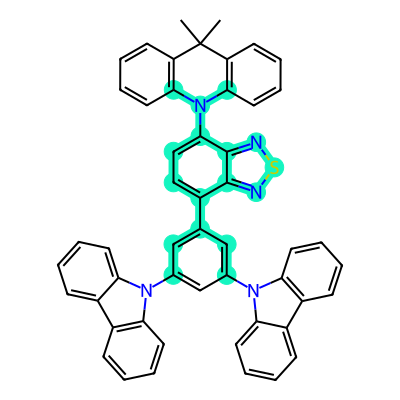

Molecule_BTD-4APOc
Morgan Fingerprint: 2001
Smiles: CCCCCCCC[n+]1ccc(Nc2cccc3nsnc23)cc1


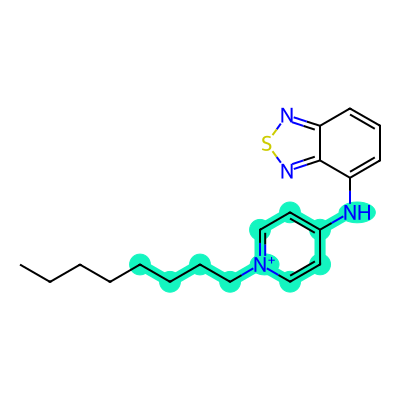

Molecule_5c
Morgan Fingerprint: 837
Smiles: C1Cc2ccccc2N(c3ccccc13)c4ccc(N5c6ccccc6CCc7ccccc57)c8nsnc48


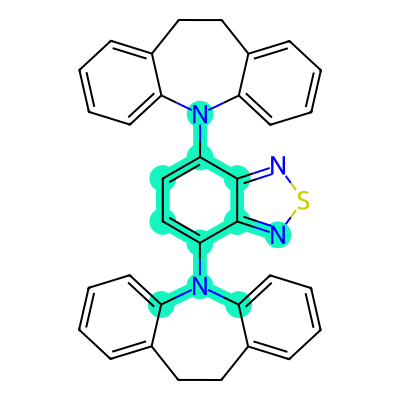

Molecule_T1
Morgan Fingerprint: 881
Smiles: C1=CC=C(C=C1)N(C2=CC=CC=C2)C3=CC=C(C=C3)C=CC4=CC=C(C5=NSN=C45)C=CC6=CC=C(C=C6)N(C7=CC=CC=C7)C8=CC=CC=C8


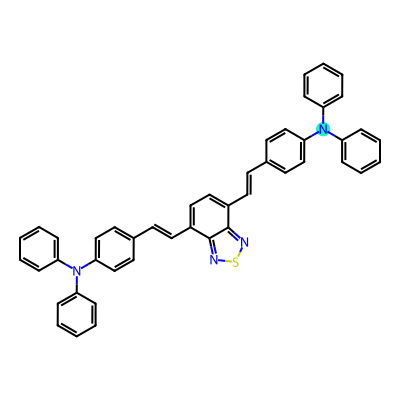

Molecule_LD-BTD-1
Morgan Fingerprint: 1163
Smiles: CN(C)C1=CC=C(C=C1)C2=CC=CC3=NSN=C23


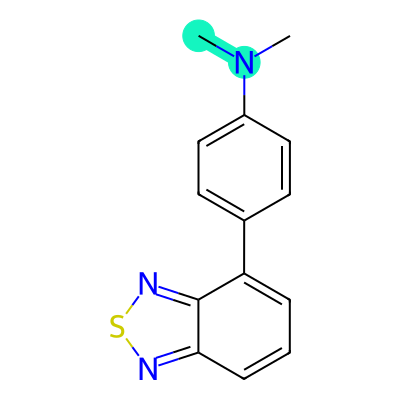

Molecule_BTDBI
Morgan Fingerprint: 914
Smiles: Oc6ccc(Nc5cc(Nc3ccc(O)c(c2nc1ccccc1[nH]2)c3)c4nsnc4c5)cc6c8nc7ccccc7[nH]8


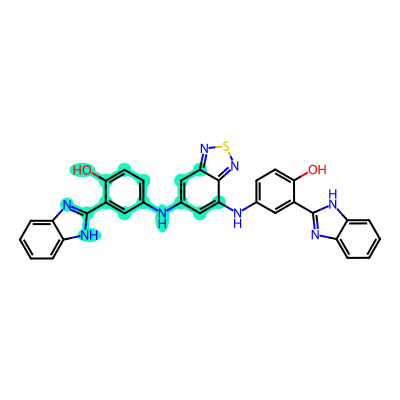

Molecule_BTD-4APBuP
Morgan Fingerprint: 1443
Smiles: C(CC[P+](c1ccccc1)(c2ccccc2)c3ccccc3)C[n+]4ccc(Nc5cccc6nsnc56)cc4


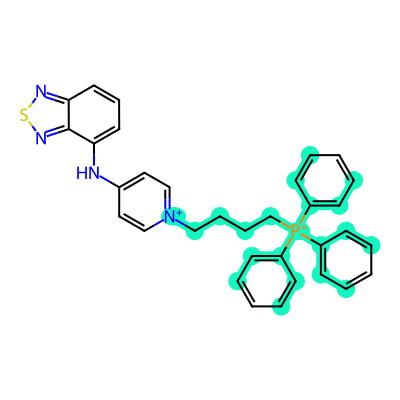

Molecule_5d
Morgan Fingerprint: 842
Smiles: C1C=CC2OC3C=CC=CC=3N(C3C4C(=NSN=4)C(N4C5C=CC=CC=5OC5C=CC=CC4=5)=CC=3)C=2C=1


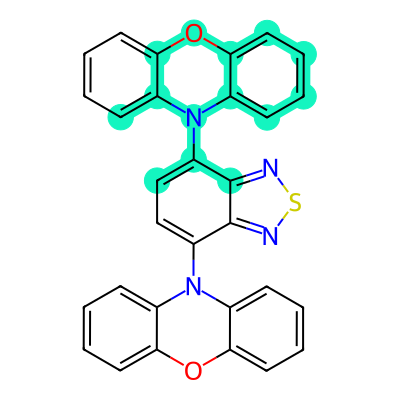

Molecule_BTD-4APBuP
Morgan Fingerprint: 1544
Smiles: C(CC[P+](c1ccccc1)(c2ccccc2)c3ccccc3)C[n+]4ccc(Nc5cccc6nsnc56)cc4


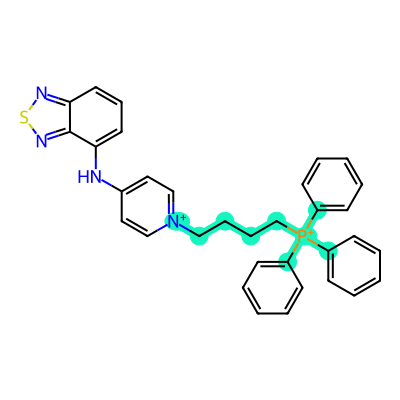

Molecule_BTDImMe
Morgan Fingerprint: 1003
Smiles: C[n+]1ccn(c1)c2ccc(n3cc[n+](C)c3)c4nsnc24


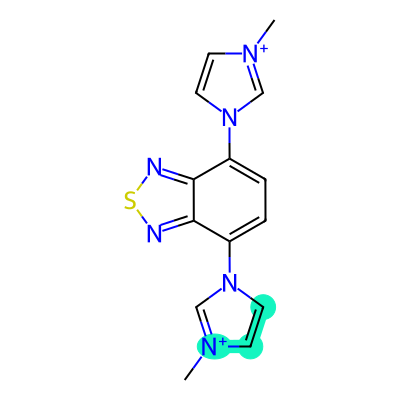

In [28]:
from drawSmiles import *
import cairosvg

NamesMol = data['molecule']
SolventMol = data['solvent']

best_radius = 4
best_length = 2048

IPythonConsole.ipython_useSVG = True 

bits = [int(x.split('_')[1]) for x in top10_morgan['col_name'] if x.startswith('MF_')]

for j in bits:
    bit_number = j
    molNumber = morgan_df.loc[morgan_df['MF_{}'.format(bit_number)] == 1].index[0]
        
    smiles = data['smiles'].iloc[molNumber]

    mol = Chem.MolFromSmiles(smiles)
    
    addcords(mol)
    info = {}

    fp = AllChem.GetMorganFingerprintAsBitVect(mol,radius=best_radius,bitInfo=info,nBits=best_length)

    X = draw_molecule_and_bit_info_grid(mol,info,bit_number, 400)
    cairosvg.svg2png(X.data, write_to='Morgan_Fingerprint_{}.png'.format(bit_number))
  
    print('Molecule_{}'.format(NamesMol[molNumber]))
    print('Morgan Fingerprint: {}'.format(bit_number))
    print('Smiles: {}'.format(data['smiles'].iloc[molNumber]))  
    display(X)